# **Extracting Topic model by  "Latent Dirichlet Allocation (LDA)"  of kepler's book: "Astronomia Nova** "
<font size="4">
This notebook demonstrates how to **extract topics **  from documents, corpus, book. We visualize the result in an informative way. Here, an unsupervised learning model LDA is used. **Topic modelling** is based on the basic assumptions that each corpus (book)  consists of different topics and each topic consists of a collection of words.
<font/>


### Import the required tools 

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import collections
import os
import logging
import warnings
from itertools import permutations
from sklearn.metrics import make_scorer,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import sklearn_crfsuite  # to install this package in windows with pip please run: 'pip install sklearn-crfsuite'
from sklearn_crfsuite import metrics, scorers
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import eli5  # to install this package in windows with conda please run: 'conda install -c conda-forge eli5'
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from gensim import corpora, models  #  to install this package in windows with conda please run: 'models conda install -c conda-forge gensim'
nltk.download('wordnet')
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Please download the data '01_df_v013.pickle' in github on  your local machine from  this directory: vorlesung2019/notebooks/yeghaneh/data

In [2]:
importVersion = '013'  # The  desired version pickle-file of your data (now we are working on version 013 of our data)

In [90]:
path = '../data/01_df_v{0}.pickle'.format(importVersion)  # Put the path of the data in your local machine here, consider the letter "r" before the path

### Let's use data "01_df_v013" to build a NER system. 
<font size="3">The data 01_df_v013 is annotated (labeled) data of english version of well-known kepler's book: New Astronomy (Latin: Astronomia nova). You can find that in the repository.
             </font>


## **Read the data** 
<font size="3">The data  is saves as a pickle file. We read it as a pandas dataFrame. </font>

In [91]:
dfAstroNova = pd.read_pickle(path)  # Put the path of the data in your local machine here, consider the letter "r" before the path

<font size="4"> Sort the data based on the chapters of the book 
</font>

In [92]:
dfAstroNova['chapter'] = dfAstroNova.chapter.replace("appendix b",np.nan).astype(float)  
dfAstroNova.sort_values(by='chapter' , inplace=True)
dfAstroNova.chapter.fillna('appendix b', inplace=True)

In [93]:
len(dfAstroNova)   # Number of rows.

1605

In [94]:
dfAstroNova.head(5)  

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
18,"<p><span class=""anchor"" id=""bookmark0""></span>...",Chapter 1,[],[],1,[],[],[],[Chapter 1],"[[(Chapter, None), (1, NUM)]]"
34,"<p>But before that, I shall prove in this firs...","But before that, I shall prove in this first p...",[],[],1,[],[],[],"[But before that, I shall prove in this first ...","[[(But, None), (before, None), (that, None), (..."
33,<p>But since the sun's mean and apparent motio...,But since the sun's mean and apparent motions*...,[],"[Mysterium cosmographicum,]",1,[],[],[ Terms: * The sun's apparent position is that...,[But since the sun's mean and apparent motions...,"[[(But, None), (since, None), (the, None), (su..."
32,<p>Now the causes and measures of these inequa...,Now the causes and measures of these inequalit...,[],[],1,[],[],[ 5],[Now the causes and measures of these inequali...,"[[(Now, None), (the, None), (causes, None), (a..."
30,"<p>Again, however, it was noticed that these l...","Again, however, it was noticed that these loop...",[],[],1,[],[],[],"[Again, however, it was noticed that these loo...","[[(Again, None), (however, None), (it, None), ..."


In [95]:
dfAstroNova[740:745]

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
594,"<p><span class=""anchor"" id=""bookmark1""></span>...","Whether the motion from the sun, like its ligh...",[{'#fn1': 'άντίφραχις.↩'}],[],35,[],[],[],"[Whether the motion from the sun, like its lig...","[[(Whether, None), (the, None), (motion, None)..."
596,"<p>And concerning the first, it is worthy of c...","And concerning the first, it is worthy of cons...",[],[],35,[],[],[],"[And concerning the first, it is worthy of con...","[[(And, None), (concerning, None), (the, None)..."
595,<p>This is a good time for me to take up the o...,This is a good time for me to take up the obje...,[],[species],35,[],[],[],[This is a good time for me to take up the obj...,"[[(This, None), (is, None), (a, None), (good, ..."
598,"<p>But it is answered, first, that the analogy...","But it is answered, first, that the analogy be...",[],[],35,[],[],[],"[But it is answered, first, that the analogy b...","[[(But, None), (it, None), (is, None), (answer..."
599,<p>On this account I would nearly separate lig...,On this account I would nearly separate light ...,[],[],35,[],[],[],[On this account I would nearly separate light...,"[[(On, None), (this, None), (account, None), (..."


In [96]:
dfAstroNova[1585:1590]

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
1568,<p>{marginal: The words of the observation hav...,Consider whether the meaning could be this: t...,[],[],70,[],[],[ The words of the observation have their comm...,[Consider whether the meaning could be this: t...,"[[(Consider, None), (whether, None), (the, Non..."
1569,<p>This interpretation is furthered by the obs...,This interpretation is furthered by the observ...,[],[],70,[],[],[],[This interpretation is furthered by the obser...,"[[(This, None), (interpretation, None), (is, N..."
0,<p>Appendix B</p>,Appendix B,[],[],appendix b,[],[],[],[Appendix B],"[[(Appendix, None), (B, None)]]"
1,"<p><span class=""anchor"" id=""bookmark0""></span>...",On the Table of Oppositions in Chapter 15,[],[],appendix b,[],[],[],[On the Table of Oppositions in Chapter 15],"[[(On, None), (the, None), (Table, None), (of,..."
2,"<p>by Yaakov Zik <span style=""font-variant: sm...",by Yaakov Zik Table i:,[],[],appendix b,[],[],[],[by Yaakov Zik Table i:],"[[(by, None), (Yaakov, None), (Zik, None), (Ta..."


In [97]:
dfAstroNova.tail(5)

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
13,<p>{table: appendix B t 2}</p>,,[],[],appendix b,[],[ appendix B t 2],[],[],[]
14,"<p>Kepler's table, for comparison {table: appe...","Kepler's table, for comparison",[],[],appendix b,[],[ appendix B t 3],[],"[Kepler's table, for comparison]","[[(Kepler, None), (s, None), (table, None), (f..."
15,<p>Mars from Earth to be a little greater than...,Mars from Earth to be a little greater than ha...,[{'#fn6': ' Kepler's observations yield topoce...,[],appendix b,[],[],[],[Mars from Earth to be a little greater than h...,"[[(Mars, None), (from, None), (Earth, None), (..."
16,"<p><img height=""300"" src=""media/image1.jpeg"" w...","As shown in Figure 2B, the Sun is assumed to ...",[],[],appendix b,[ appendix b gr 1],[],[],"[As shown in Figure 2B, the Sun is assumed to ...","[[(As, None), (shown, None), (in, None), (Figu..."
17,<p>The Sun moved westward and its longitude de...,The Sun moved westward and its longitude decre...,[],[4<sup>h</sup> 23<sup>m </sup>],appendix b,[],[],[],[The Sun moved westward and its longitude decr...,"[[(The, None), (Sun, None), (moved, None), (we..."


## **Primary Data Exploration**

In [98]:

dfAstroNova["text"][5]    # 5th row of the data in the format of text 

"The time is measured from midnight; Gregorian dates are obtained by adding 10 days to Kepler's dates. The dates are given in old style."

In [99]:
dfAstroNova["tagged"][5] # 5th row of the data in a format (token, label). A list of lists of tuples! later position tags of the token will be added to each tuple. the tokens are chosen before by some rules.

[[('The', 'None'),
  ('time', 'None'),
  ('is', 'None'),
  ('measured', 'None'),
  ('from', 'None'),
  ('midnight', 'None'),
  ('Gregorian', 'None'),
  ('dates', 'None'),
  ('are', 'None'),
  ('obtained', 'None'),
  ('by', 'None'),
  ('adding', 'None'),
  ('10', 'NUM'),
  ('days', 'None'),
  ('to', 'None'),
  ('Kepler', 'None'),
  ('s', 'None'),
  ('dates', 'None')],
 [('The', 'None'),
  ('dates', 'None'),
  ('are', 'None'),
  ('given', 'None'),
  ('in', 'None'),
  ('old', 'None'),
  ('style', 'None')]]

In [100]:
dfAstroNova= dfAstroNova.loc[dfAstroNova.chapter==5]

In [101]:
 df = sum(dfAstroNova['tagged'], [])  # Flatt the data by removing first lists
len(df)

178

In [102]:
df[5]  

[('Thus', 'None'),
 ('in', 'None'),
 ('both', 'None'),
 ('instances', 'None'),
 ('the', 'None'),
 ('planet', 'None'),
 ('is', 'None'),
 ('always', 'None'),
 ('on', 'None'),
 ('a', 'None'),
 ('line', 'None'),
 ('drawn', 'None'),
 ('from', 'None'),
 ('γ', 'None'),
 ('at', 'None'),
 ('the', 'None'),
 ('point', 'None'),
 ('where', 'None'),
 ('that', 'None'),
 ('line', 'None'),
 ('cuts', 'None'),
 ('one', 'None'),
 ('or', 'None'),
 ('another', 'None'),
 ('eccentric', 'None')]

In [103]:
df_flatten = sum(df,[])  # Flatt the data by removing the second list


In [104]:
df_flatten[0:20]  # Here we have tokens (entities) with their labels

[('To', 'None'),
 ('find', 'None'),
 ('the', 'None'),
 ('basis', 'None'),
 ('of', 'None'),
 ('a', 'None'),
 ('computation', 'None'),
 ('whereby', 'None'),
 ('we', 'None'),
 ('may', 'None'),
 ('investigate', 'None'),
 ('for', 'None'),
 ('the', 'None'),
 ('observer', 'None'),
 ('at', 'None'),
 ('δ', 'None'),
 ('how', 'None'),
 ('much', 'None'),
 ('his', 'None'),
 ('appearances', 'None')]

In [105]:
len(df_flatten)  # Number of all tokens (roughly speaking all words or entities)

5650

In [106]:

tokens = [x[0] for x in df_flatten]  # Extract the tokens for further use in the frequency plot

In [107]:
labels=([x[1] for x in df_flatten])  # Extract the labels for further use in the frequency plot

In [108]:
tokens[0:5]

['To', 'find', 'the', 'basis', 'of']

In [109]:
labels[0:5]

['None', 'None', 'None', 'None', 'None']

## **Visualization**

### Frequency plot of all words in all chapter of book

<font size="3">
Frequency plot of all tokens in text, as you see there is a lot 'the', 'of',... in text, they normally consider as noise, we will back to that later.
<font/>

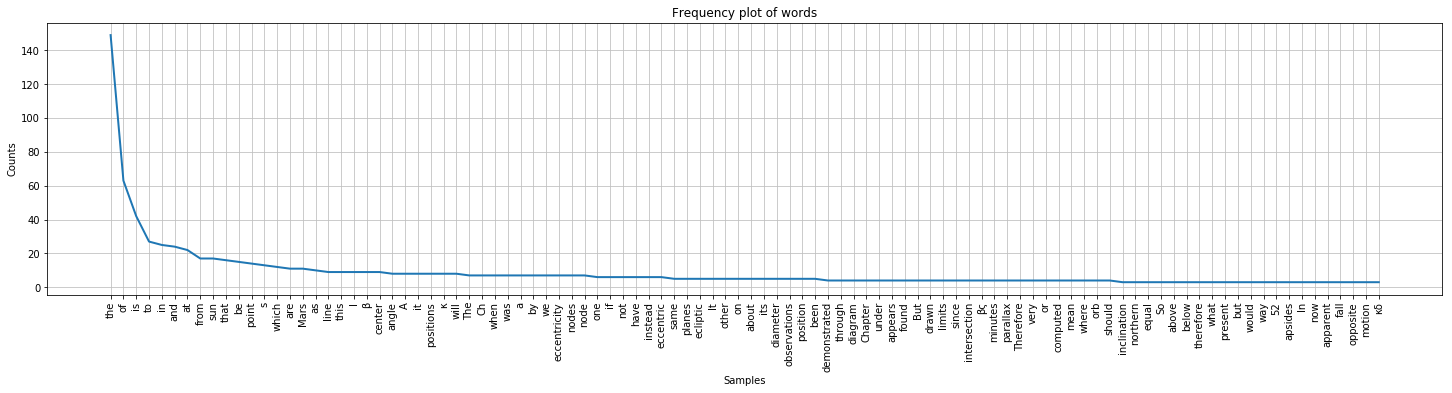

In [61]:
freqdist = nltk.FreqDist(tokens)
plt.figure(figsize=(25,5))
freqdist.plot(100, title='Frequency plot of words')


In [62]:
stop_words=["the", "of", "is", "to", "and","in", "be", "at", "that", "from", "it", "a", "as","this", "was" ] # we can consider these as stop words or we can use nltk stop words.

In [63]:
# nltk stop words
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
stop_words=stop_words.union(['I', 'And', 'For', 'A', 'The'])
#stop_words_nltk = set(stop_words)

# List of nltk stop words {‘ourselves’, ‘hers’, ‘between’, ‘yourself’, ‘but’, ‘again’, ‘there’, ‘about’, ‘once’, ‘during’, ‘out’, ‘very’, ‘having’, ‘with’, ‘they’, ‘own’, ‘an’, ‘be’, ‘some’, ‘for’, ‘do’, ‘its’, ‘yours’, ‘such’, ‘into’, ‘of’, ‘most’, ‘itself’, ‘other’, ‘off’, ‘is’, ‘s’, ‘am’, ‘or’, ‘who’, ‘as’, ‘from’, ‘him’, ‘each’, ‘the’, ‘themselves’, ‘until’, ‘below’, ‘are’, ‘we’, ‘these’, ‘your’, ‘his’, ‘through’, ‘don’, ‘nor’, ‘me’, ‘were’, ‘her’, ‘more’, ‘himself’, ‘this’, ‘down’, ‘should’, ‘our’, ‘their’, ‘while’, ‘above’, ‘both’, ‘up’, ‘to’, ‘ours’, ‘had’, ‘she’, ‘all’, ‘no’, ‘when’, ‘at’, ‘any’, ‘before’, ‘them’, ‘same’, ‘and’, ‘been’, ‘have’, ‘in’, ‘will’, ‘on’, ‘does’, ‘yourselves’, ‘then’, ‘that’, ‘because’, ‘what’, ‘over’, ‘why’, ‘so’, ‘can’, ‘did’, ‘not’, ‘now’, ‘under’, ‘he’, ‘you’, ‘herself’, ‘has’, ‘just’, ‘where’, ‘too’, ‘only’, ‘myself’, ‘which’, ‘those’, ‘i’, ‘after’, ‘few’, ‘whom’, ‘t’, ‘being’, ‘if’, ‘theirs’, ‘my’, ‘against’, ‘a’, ‘by’, ‘doing’, ‘it’, ‘how’, ‘further’, ‘was’, ‘here’, ‘than’} 


<font size="3">
We can consider these words like 'the', 'of',... as noises. so we temporary remove those! 
<font/>

In [64]:
new_tokens = []     
for w in tokens:
    if w not in stop_words: new_tokens.append(w)      

### Frequency plot of all words in all chapter of book after removing the stop words

<font size="3">
It shows word "sun" is most common word.  We can also see the word Mars, planet, eccentric as common words in the book 
<font/>

# CHAPTER 3

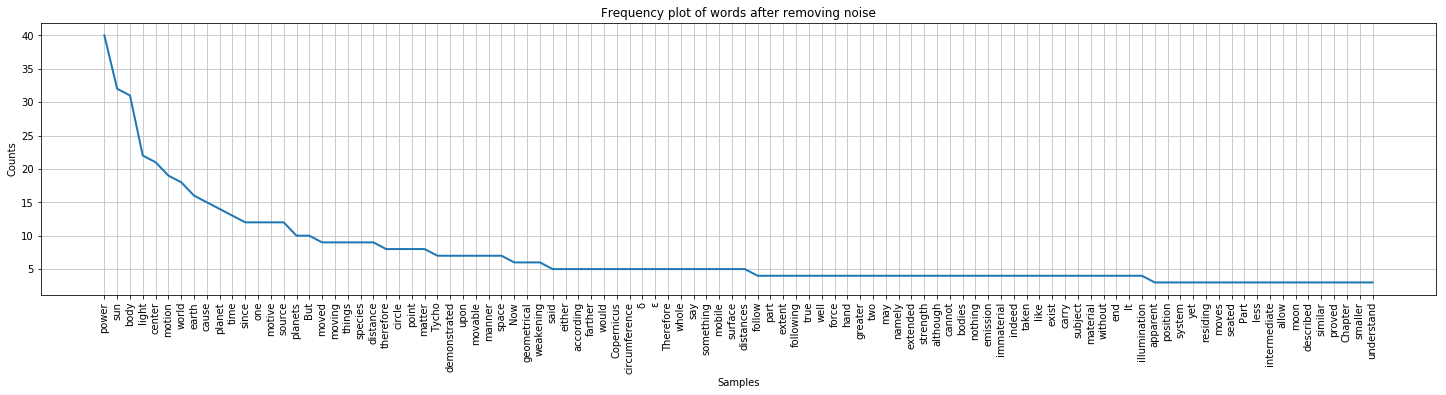

In [27]:
freqdist = nltk.FreqDist(new_tokens) 
plt.figure(figsize=(25,5)) 
freqdist.plot(100, title='Frequency plot of words after removing noise')

# CHAPTER 67

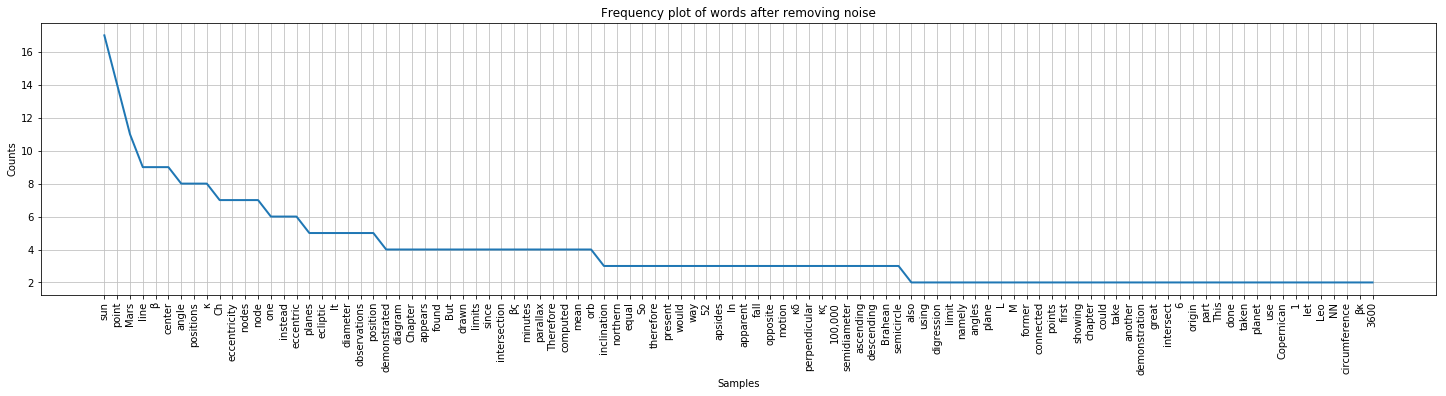

In [65]:
freqdist = nltk.FreqDist(new_tokens) 
plt.figure(figsize=(25,5)) 
freqdist.plot(100, title='Frequency plot of words after removing noise')

<font size="4">
Do we need more insight than frequency plot of word for see content of the book? the question is answered by the follwoing cells through investigation of "topic modelling"
<font/>

## **Topic Modelling by LDA**

 Here you see an structured workflow to build an insightful "topic model" based on the Latent Dirichlet Allocation (LDA) algorithm,  modeled as Dirichlet distributions Dir(α).
 For more detail you can read: <p>
http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
    </p>

### **Pre-processing**

<font size="3">
Since we alreay tokenized the text (split text into  word without punctuation) and removed stopwrods, we only need to **lemmatize** and **stemm** the tokens.
<font/>

In [110]:
mytext = nltk.Text(new_tokens) 


#### Lemmatization 

<font size="3">
Lemmatization, takes into consideration the morphological analysis of the words. For instance  "do", "does", "did" and "doing" are forms of the same lexeme with "do" as the lemma. Another example would be  "car", "cars", "automobile"
<font/>

In [111]:
#lemmatization
w_lemmatize= WordNetLemmatizer()
my_text_lemmatize = [w_lemmatize.lemmatize(word) for word in mytext]


#### Stemming

<font size="3">
Stemming algorithms work by cutting off the end or the beginning of the word, by taking into account a list of common prefixes and suffixes. It reduces words to their word stem or root form. For instance, stemming for root word "like" include:"likes", "liked", "likely", "liking
<font size=/>

In [112]:
# stemming 
p_stemmers=PorterStemmer()  
my_text_lemm_stemmer = [p_stemmers.stem(word) for word in my_text_lemmatize]

In [113]:
my_text_lemm_stemmer=[my_text_lemm_stemmer] #make a list of list

#### Select a document to preview after preprocessing.

In [114]:
Dic=corpora.Dictionary(my_text_lemm_stemmer)

### **Bag of Words on the Data set**

<font size="4">
Our dictionary must be converted to "bag of word". Frequency of occurrence of each word is used as a feature for training a classifier. It means it should contain the number of times a word appears
<font size>

In [115]:
corpus = [Dic.doc2bow(text) for text in my_text_lemm_stemmer]

#### Running LDA using Bag of Words**

In [126]:
ldamodel =models.ldamodel.LdaModel(corpus, num_topics=3,  id2word = Dic, passes=2, iterations=20)

In [127]:
lda_topics=ldamodel.print_topics()

In [128]:
lda_topics

[(0,
  '0.024*"sun" + 0.021*"node" + 0.020*"point" + 0.018*"eccentr" + 0.016*"posit" + 0.016*"mar" + 0.014*"angl" + 0.013*"center" + 0.013*"β" + 0.013*"line"'),
 (1,
  '0.013*"sun" + 0.010*"posit" + 0.010*"eccentr" + 0.010*"point" + 0.010*"node" + 0.009*"mar" + 0.008*"demonstr" + 0.008*"angl" + 0.008*"line" + 0.008*"center"'),
 (2,
  '0.021*"point" + 0.018*"eccentr" + 0.018*"posit" + 0.016*"sun" + 0.013*"node" + 0.012*"mar" + 0.011*"κ" + 0.011*"angl" + 0.011*"β" + 0.011*"demonstr"')]

In [129]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, Dic)


# Topic Modelling of chapter 5 

In [130]:
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0     -0.007071 -0.0       1        1  97.050346
2     -0.001246 -0.0       2        1   2.891311
1      0.008317 -0.0       3        1   0.058344, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
238   Default  14.000000        sun  14.000000  30.0000  30.0000
199   Default  12.000000      point  12.000000  29.0000  29.0000
119   Default  10.000000    eccentr  10.000000  28.0000  28.0000
180   Default  13.000000       node  13.000000  27.0000  27.0000
200   Default   9.000000      posit   9.000000  26.0000  26.0000
169   Default   9.000000        mar   9.000000  25.0000  25.0000
65    Default   8.000000       angl   8.000000  24.0000  24.0000
164   Default   7.000000       line   7.000000  23.0000  23.0000
86    Default   7.000000     center   7.000000  22.0000  22.0000
273   Default   7.000000          β   7.000000  21.0000  21.0000
106   Default   6.000000   demonstr   6.000000  20.0000  20.0000
279   Default   6.000000          κ   6.000000  19.0000  19.0000
196   Default   6.000000      plane   6.000000  18.0000  18.0000
43    Default   5.000000         Ch   5.000000  17.0000  17.0000
245   Default   5.000000   therefor   5.000000  16.0000  16.0000
186   Default   5.000000        one   5.000000  15.0000  15.0000
163   Default   4.000000      limit   4.000000  14.0000  14.0000
88    Default   6.000000    chapter   6.000000  13.0000  13.0000
155   Default   5.000000  intersect   5.000000  12.0000  12.0000
154   Default   5.000000    instead   5.000000  11.0000  11.0000
111   Default   5.000000     diamet   5.000000  10.0000  10.0000
120   Default   4.000000     eclipt   4.000000   9.0000   9.0000
137   Default   4.000000       fall   4.000000   8.0000   8.0000
229   Default   4.000000       sinc   4.000000   7.0000   7.0000
259   Default   4.000000        use   4.000000   6.0000   6.0000
184   Default   4.000000     observ   4.000000   5.0000   5.0000
188   Default   4.000000        orb   4.000000   4.0000   4.0000
47    Default   3.000000         It   3.000000   3.0000   3.0000
68    Default   3.000000     appear   3.000000   2.0000   2.0000
172   Default   3.000000       mean   3.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
110    Topic3   0.001889    diagram   3.364379  -0.0386  -5.2486
119    Topic3   0.003647    eccentr  10.972180  -0.5627  -4.5906
163    Topic3   0.002299      limit   4.895588  -0.2170  -5.0519
173    Topic3   0.001875      minut   3.457600  -0.0731  -5.2558
169    Topic3   0.003238        mar   9.702831  -0.5586  -4.7095
1      Topic3   0.001562    100,000   2.531735   0.0559  -5.4384
47     Topic3   0.001888         It   3.612744  -0.1099  -5.2487
95     Topic3   0.001830     comput   3.409601  -0.0836  -5.2803
199    Topic3   0.003618      point  12.504307  -0.7013  -4.5984
196    Topic3   0.002446      plane   6.052430  -0.3672  -4.9900
164    Topic3   0.002749       line   7.734763  -0.4956  -4.8732
65     Topic3   0.002930       angl   8.791186  -0.5600  -4.8095
279    Topic3   0.002472          κ   6.364773  -0.4068  -4.9793
86     Topic3   0.002706     center   7.780268  -0.5173  -4.8889
180    Topic3   0.003441       node  13.083817  -0.7967  -4.6486
137    Topic3   0.002004       fall   4.354691  -0.2373  -5.1893
186    Topic3   0.002204        one   5.414424  -0.3600  -5.0942
245    Topic3   0.002186   therefor   5.460977  -0.3765  -5.1022
43     Topic3   0.002263         Ch   5.925083  -0.4238  -5.0679
155    Topic3   0.002118  intersect   5.169193  -0.3532  -5.1338
99     Topic3   0.001615     consid   2.909600  -0.0499  -5.4052
172    Topic3   0.001796       mean   3.705739  -0.1853  -5.2987
273    Topic3   0.002473          β   7.745473  -0.6029  -4.9790
120    Topic3   0.001945     eclipt   4.693481  -0.3419  -5.2189
154    

# Topic Modelling of chapter 30

In [108]:
pyLDAvis.display(vis) 

# CHAPTER 67

In [83]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.004447  0.000187       1        1  93.650368
2     -0.001708 -0.001306       2        1   3.717920
0     -0.002739  0.001118       3        1   2.631707, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
238   Default  13.000000        sun  13.000000  30.0000  30.0000
199   Default  12.000000      point  12.000000  29.0000  29.0000
180   Default   9.000000       node   9.000000  28.0000  28.0000
119   Default  11.000000    eccentr  11.000000  27.0000  27.0000
200   Default  10.000000      posit  10.000000  26.0000  26.0000
169   Default   8.000000        mar   8.000000  25.0000  25.0000
65    Default   8.000000       angl   8.000000  24.0000  24.0000
273   Default   7.000000          β   7.000000  23.0000  23.0000
86    Default   7.000000     center   7.000000  22.0000  22.0000
164   Default   7.000000       line   7.000000  21.0000  21.0000
106   Default   6.000000   demonstr   6.000000  20.0000  20.0000
279   Default   7.000000          κ   7.000000  19.0000  19.0000
196   Default   5.000000      plane   5.000000  18.0000  18.0000
245   Default   5.000000   therefor   5.000000  17.0000  17.0000
43    Default   5.000000         Ch   5.000000  16.0000  16.0000
88    Default   6.000000    chapter   6.000000  15.0000  15.0000
155   Default   4.000000  intersect   4.000000  14.0000  14.0000
163   Default   5.000000      limit   5.000000  13.0000  13.0000
186   Default   5.000000        one   5.000000  12.0000  12.0000
154   Default   5.000000    instead   5.000000  11.0000  11.0000
184   Default   3.000000     observ   3.000000  10.0000  10.0000
120   Default   3.000000     eclipt   3.000000   9.0000   9.0000
47    Default   4.000000         It   4.000000   8.0000   8.0000
259   Default   4.000000        use   4.000000   7.0000   7.0000
137   Default   4.000000       fall   4.000000   6.0000   6.0000
111   Default   4.000000     diamet   4.000000   5.0000   5.0000
116   Default   3.000000      drawn   3.000000   4.0000   4.0000
83    Default   3.000000        but   3.000000   3.0000   3.0000
188   Default   4.000000        orb   4.000000   2.0000   2.0000
172   Default   3.000000       mean   3.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
54     Topic3   0.063083          P   1.911400   0.2264  -5.5490
172    Topic3   0.095623       mean   3.162494   0.1388  -5.1330
120    Topic3   0.114976     eclipt   3.952833   0.1001  -4.9487
68     Topic3   0.097285     appear   3.363366   0.0945  -5.1158
274    Topic3   0.063240         βκ   1.968090   0.1997  -5.5465
273    Topic3   0.174066          β   7.459999  -0.1203  -4.5340
199    Topic3   0.260574      point  12.726224  -0.2510  -4.1306
245    Topic3   0.140923   therefor   5.780704  -0.0765  -4.7453
200    Topic3   0.213805      posit  10.532913  -0.2597  -4.3284
47     Topic3   0.109906         It   4.259362  -0.0197  -4.9938
119    Topic3   0.226208    eccentr  11.836743  -0.3200  -4.2720
86     Topic3   0.162152     center   7.449031  -0.1898  -4.6049
43     Topic3   0.135583         Ch   5.874140  -0.1312  -4.7839
238    Topic3   0.240771        sun  13.854361  -0.4150  -4.2096
203    Topic3   0.077622    present   2.653452   0.1058  -5.3416
169    Topic3   0.172598        mar   8.812516  -0.2954  -4.5425
163    Topic3   0.118419      limit   5.029032  -0.1112  -4.9192
88     Topic3   0.135177    chapter   6.230045  -0.1930  -4.7869
106    Topic3   0.136023   demonstr   6.399256  -0.2136  -4.7806
32     Topic3   0.079476         52   2.871593   0.0504  -5.3180
65     Topic3   0.151444       angl   8.565643  -0.3978  -4.6732
186    Topic3   0.112338        one   5.666420  -0.2833  -4.9720
154    Topic3   0.111107    instead   5.711200  -0.3022  -4.9830
243    Topic3   0.087487       take   3.609028 

In [78]:
pyLDAvis.save_html(vis,'vis.html') # You can open saved html file  (vis_01)in your browser to see the result. 

<font size= "4">
How can we find that how many topics are proper for the model?
<font/>

## **Coherence Metric**